# Checkpoint 1: Neural networks and deep learning
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)

In this checkpoint exercise, we will use neural networks to predict the **type** of weather *given* the available ground observations. You will be using observation data from **June 2019** across all UK Met Office weather stations.

### Notes on the Dataset
* You will be using weather observation data from the UK Met Office Datapoint service
* Ground observations are made hourly at weather stations across the length of the UK 
* The data sample covers data from June 2019
* Data collections for each day starts at 6.30pm. All observation data is listed in one day blocks
* The time value column refers to the number of minutes after midnight 
* `Null` values for some features are expected (e.g. Wind Gust)
* Data import and preparation is already provided 


This week, I am not providing example notebooks like `lecture2.ipynb` and `data-science-tools.ipynb` for Unit 2, though these may still be useful to you. Instead, I am **providing the imports for all of the modules and classes that you should need.** Think of these as LEGO blocks; you have the ones you need but may look up how to "assemble" them.

### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10am on Friday 9 October 2021** 
- This CP exercise sheet is divided into **6 sections**, corresponding to parts of the lecture, giving a maximum of **10 marks** in total:

| <p align='left'> Title                         | <p align='left'> Exercise nos. | <p align='left'> Number of marks |
| ------------------------------------- | ----- | --- |
| <p align='left'> 1. Conceptual questions               | <p align='left'>  1–5  | <p align='left'> 3 |
| <p align='left'> 2. Data preprocessing and RandomForest                | <p align='left'>  6–9  | <p align='left'> 2. |
| <p align='left'> 3. Neural networks in `scikit-learn`  | <p align='left'>  10–11 | <p align='left'> 1.5 | 
| <p align='left'> 4. Neural networks in `Keras`         | <p align='left'> 12–13 | <p align='left'> 2 |
| <p align='left'> 5. Regularisation                     | <p align='left'> 14–15 | <p align='left'> 1.5 |
| <p align='left'> **Total** | | <p align='left'> **10** |

- The total number of marks allocated for this CP is 10,
    - 1 additional mark can be given (maximimally up to 10 marks in total) for "bonus" exercise on hyperparameter optimisation. If you are pressed for time, focus on the first five sections; those are the core ones.
    - Half marks may be deducted for code legibility (i.e. very difficult to tell what you are doing), or for badly formated plots (i.e. no legends, axis labels etc.). The TAs will use their discression for this so comment code when applicable and keep relevant information in your plots.

_Note:_ You can suppress double-printing of plots from the `plot` module by either _(a)_ adding a semicolon after the function call (_i.e._ `plot.<method>(...);`), or _(b)_ by capturing the return `pyplot.Figure` object as a variable (_i.e._ `fig = plot.<method>(...)`).

## Preamble

In [2]:
# Standard import(s)
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.inspection import PartialDependenceDisplay
%matplotlib inline


from sklearn import metrics

# Suppress unnecessary ConvergenceWarnings and DeprecationWarnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

# Set a random seed variable to make workbook reproducible
seed=5
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

# Switch off multi-threading for TensorFlow
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
K.set_session(sess)

In [3]:
# Load in the prepared weather data
obs = pd.read_csv('weather.csv')
obs.head()

,StationID,StationName,Elevation,Latitude,Longitude,Date,Time,Gust,Temperature,Visibility,WindDirection,WindSpeed,Pressure,PressureTrend,DewPoint,Humidity,Type
0,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1020,NaN,16.1,30000.0,E,8.0,1019.0,F,11.6,74.5,0
1,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1080,NaN,14.9,22000.0,E,8.0,1019.0,F,11.8,81.5,0
2,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1140,NaN,14.0,14000.0,E,6.0,1018.0,F,11.6,85.4,0
3,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1200,NaN,12.9,12000.0,ENE,2.0,1019.0,R,11.0,88.1,0
4,3002,BALTASOUND,15.0,60.749,-0.854,2018-05-31,1260,NaN,12.0,9000.0,E,2.0,1019.0,R,10.9,92.9,1


In [4]:
obs.shape

(106553, 17)

In [5]:
obs.describe()

,StationID,Elevation,Latitude,Longitude,Time,Gust,Temperature,Visibility,WindSpeed,Pressure,DewPoint,Humidity,Type
count,106553.000000,106553.000000,106553.000000,106553.000000,106553.000000,7703.000000,106442.000000,92662.000000,102060.000000,99530.000000,106402.000000,106397.000000,106553.00000
mean,6147.845636,114.466594,53.673022,-2.829034,702.914418,33.043749,14.958912,25698.164404,8.999510,1018.748337,10.348008,76.185240,0.99603
std,15821.503845,171.669120,2.466079,2.269594,412.057262,13.424855,4.294516,14263.873943,6.087882,6.327468,3.120565,17.208653,0.92971
min,3002.000000,2.000000,49.207900,-10.250000,0.000000,0.000000,-1.200000,20.000000,0.000000,976.000000,-28.200000,0.800000,0.00000
25%,3204.000000,20.000000,51.565000,-4.149000,360.000000,29.000000,12.000000,14000.000000,5.000000,1015.000000,8.400000,65.300000,0.00000
50%,3414.000000,65.000000,53.175000,-2.663000,720.000000,32.000000,14.500000,25000.000000,8.000000,1018.000000,10.500000,79.200000,1.00000
75%,3769.000000,132.000000,55.285000,-1.097000,1020.000000,39.000000,17.500000,35000.000000,11.000000,1024.000000,12.500000,90.000000,1.00000
max,99142.000000,1245.000000,60.749000,1.348000,1380.000000,105.000000,31.600000,75000.000000,81.000000,1036.000000,22.700000,100.000000,3.00000


For this exercise we will use **8** input features (provided) and clean the data:

In [6]:
# Define 8 input feature variables, 1 target variable data, and names of the 3 weather types
features = ['Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity', 'WindDirection']
output   = ['Type']
wtype    = ['Clear', 'Cloudy', 'Precip']

Define derived dataset containing only the relevant columns and rows.

In [7]:
# Reduce to feature and type columns
dataset = obs[features + output]

# Drop duplicates and null values 
dataset = dataset.drop_duplicates().dropna()

# Drop unrecorded weather type
dataset = dataset[dataset.Type != 3]

# Check shape 
dataset.shape

(86313, 9)

## 1. Conceptual questions (3 Marks)
---
This section covers **5** exercises on conceptual understanding of neural networks.

#### 1.1. Which are the most used activation functions and why do we (typically) need non-linear activation functions in neural networks? (0.5 mark)

In [8]:
#Sigmoid activation, RelU, Softmax and tanh
#We need non-linear functions so that the neural network can do more complex tasks. In order to perform backpropogation, we 
#need to differentiate a non-linear function otherwise the derivative is constant and thus independent of the input.
#Linear functions are composed of linear parts so Hidden layers would be useless without non-linear activation functions.

#### 1.2. Why do we need deep neural networks and which are the main differences between deep and shallow learning? (0.5 Mark)

#The performance of Deep learning algorithms scales much better with the amount of data than other learning algorithms 
#making it more accurate and high performance on when given complex tasks.
#Deep neural networks are able to get the relevant features whereas for shallow neural networks we must provide them.
#Deep neural networks have two or more hidden layers
#Deep neural networks can make use of high dimensional data whereas shallow neural networks cannot.


#### 1.3. Discuss the Bias-variance trade-off and its relation to underfitting and overfitting of a model. Which are the caractheristics of an ideal model?  (0.5 mark)

In [9]:
#If you increase the bias of an algorithm  then you decrease the variance and vice versa. This is the Biad-variance trade-off.
#An algorithm with low bias and high variance has been overfit (High loss on trsting data)
#An algorithm with high bias and low variance has been underfit (poor performance on training data)
#Ideal models have a low bias and a low variance.


#### 1.4. Given a neural network with 4 input nodes, 2 layers with 5 nodes each, and 1 output node, what is the total number of free (trainable) parameters in the network? Does it matter which activation function(s) are used?  (0.5 mark)

In [10]:
#free parameters from bias = 5 x 2 + 1 = 11
#free parameters from connections between layers = (4x5)+(5x5) + (5x1) = 20+25+5 = 50

#free paramaters = 61
#this is independent of the activation function

#### 1.5. What are appropriate choice for _(a)_ the number of output nodes and _(b)_ output activation function(s) for each of the following tasks, and why? (0.5 mark)

1. Regression of the $x$, $y$, and $z$ coordinates of a single particle in an arbitrary coordinate system
2. Regression of particle energy of a single particle
3. Classification of two processes (signal vs. background)
4. Classification among *N* classes (dog vs. cat vs. fish vs. ...)

In [11]:
#1.a) 3 output nodes ,b) RelU, because it is fast to converge and avoids vanishing gradients
#2.a) 1 output node  ,b) RelU, because it is fast to converge and avoids vanishing gradients
#3.a) 2 output nodes ,b) sigmoid function because it only exists between 0 and 1 which is useful since we want probability outputs.
#4.a) N output nodes ,b) softmax activation function, because it assigns 0 to 1 that must sum to 1 between all classes

**1.6. Given some data points and regression/classification problem, write the appropite cost function and compare your solution to that from sklearn (0.5 marks)** 

**Regression** 

A good **loss function** for regression is the **Mean Squared Error**. 

For $N$ samples with targets $Y$, our prediction $\bar{Y}$ has an MSE of:


$\mathrm{MSE} = \frac{\sum[(\bar{Y}-Y)^2]}{N}$

In [12]:
## Regression Problem

# 3 Targets for regression 
Y = np.array([0.,1.,0.5])
# 3 Predicted values (at random)
YPred = np.random.rand(3)

In [13]:
#cost function (Mean Square Error):
def mse(YPred,Y):
    error = np.sum((YPred-Y)**2)/len(Y) #equation for mean squared error target Y
    return error

In [14]:
# Comparing our function to the sklearn MSE
prediction = np.random.rand(Y.shape[0])
print ("My MSE function is {}".format("Correct" if mse(prediction,Y) == metrics.mean_squared_error(prediction,Y) else "Wrong"))

My MSE function is Correct


**Classification**

Log Loss from the lecture notes is appropiate for binary classification, where our prediction is a probaility of `label = 1`.

In [15]:
#10 Random class labels (0 or 1)
Y = np.random.randint(0,2,10)
# 10 Random Probabilities
YPred = np.random.rand(10)

In [16]:
def logloss(YPred,Y):
    logerror = (-1/len(Y))*np.sum((Y*np.log(YPred))+(1-Y)*np.log(1-YPred)) #equation for logloss with target Y
    return logerror

In [17]:
# Check it matches the sklearn log_loss
logloss(YPred,Y) == metrics.log_loss(Y.astype(int),YPred)

True

## 2. Data preprocessing and RTs (2 mark)
---
This section covers **4** exercises on data preparation, feature standardisation, and dataset splitting.

In [18]:
# Relevant import(s) for this section
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Import preprocessing for String-Int conversion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

---
**_Comment on target format and one-hot encoding:_** By default, the target column (`Type`) contains one integer (0, 1, or 2) for each example, the integer specifying one of three possible types of weather. However, for doing multi-class classification (which this is), we want our neural network to have one output node per class (_i.e._ 3 output nodes in this case), such that the activation of each output node is interpreted as the likelihood for a given sample being of the type in question. Therefore, the target should also be a 3-element vector for each sample; this vector should be all zeros, except for a $1$ at the index corresponding to the type in question. This is called **one-hot encoding**, and a few examples are shown below:

- type = 0 $\to$ one-hot = $[1, 0, 0]$ for 3 classes
- type = 1 $\to$ one-hot = $[0, 1, 0]$ for 3 classes
- type = 2 $\to$ one-hot = $[0, 0, 1]$ for 3 classes

This is the target towards which a neural network classifier is trained: That is, ideally, for an example of type 0, the network will output a large activation ($\approx 1$) on the first output node (interpreted as a large likelihood for the first weather type), and very small activations ($\ll 1$) on the two other output nodes (intepreted as small likelihoods for the two other weather types); and so on.

The same type of one-hot encoding can be performed for any number of target classes $N_{c}$, which just results in $N_{c}$-element target vectors with a single non-zero entry each.

To be user friendly, however, `scikit-learn` allows us to use integer targets for multi-class classification — it does the one-hot encoding for us "under the hood." Similarly, `keras`, _can_ also allow us to use integer targets for multi-class classification, provided we use the appropropriate loss (`sparse_categorical_crossentropy`). Otherwise (if we use `categorical_crossentropy` loss), it expects one-hot encoded targets. Which approach you choose is up to you — but now you know what goes on.

---

#### 2.1. Prepare the feature and target arrays (0.5 mark)
- Randomly sample **3,500** observations per weather type (**10,500** observations in total) from `dataset` into a new `pandas.DataFrame`; call it `sample`.
- One-hot encode the **wind direction** variable (_i.e._ $N$ to $[1, 0, \ldots, 0]$, $NNE$ to $[0, 1, \ldots, 0]$, _etc._ ), to allow us to input it to the neural network. There are 16 unique directions so we need to transform 1 feature into 16 features.
The exact order of the encoding (_i.e._ which direction corresponds to which index) doesn't matter. *Hint:*
  - *Either:* Use the scikit-learn `ColumnTransformer` with the `OneHotEncoder` applied to the `WindDirection` column, and let the remainder of the features pass through un-transformed.
  - *Or:* Use the `OneHotEncoder` class directly on the `WindDirection` column (use `sparse=False` in the `OneHotEncoder` constructor), and then concatenate with a `numpy.array` containing the remaining features.
- Define `numpy.arrays` named `X` and `y` containing the training features (the 7 unmodified ones plus the one-hot encoded wind directions) and target, respectively.
- Argue whether the shapes of `X` and `y` are as expected/as they should be.


In [19]:
#For convenience concatenate the wind direction and other features 
# in the order that you can use this feature name variable
feature_names = list(range(16))+features[:-1]
print(feature_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'Latitude', 'Elevation', 'Temperature', 'Visibility', 'WindSpeed', 'Pressure', 'Humidity']


In [20]:
#shuffle dataset


dataset = dataset.sample(frac = 1).reset_index(drop=True)  
#put 3500 observations for each weather type into a list of 3
frames =[dataset[dataset.Type == 0].head(3500),dataset[dataset.Type == 1].head(3500),dataset[dataset.Type == 2].head(3500)] 
#concatenate list to create 10500x9 dataframe
sample = pd.concat(frames)

#One-hot encode WindDirection ie split feature (index 7) into 16 features 
transformer = ColumnTransformer(transformers = [('',OneHotEncoder(),[7])],remainder = 'passthrough')

transformed = transformer.fit_transform(sample)
transformed_sample = pd.DataFrame(transformed,columns = transformer.get_feature_names_out())



In [21]:
#Separate features and target into X and y arrays respectively
X = transformed_sample[transformed_sample.columns[0:23]].values

#flatten y array to 1D
y = sample['Type'].values.flatten()
print(X.shape)
print(y.shape)
#X is (10500,23) which means it includes all 10500 data points,7 of the original features, and 16 wind direction colums 
#y is (10500,) since it is one row containing the target values for all datapoints.


(10500, 23)
(10500,)


#### 2.2. Train a Random Forest, evaluate performance, explore features (1.5 mark)

Decision trees work well with a mixture of features (of different scales, and both binary and continuous data), so we will train a random forest to do the job of categorisation.

You are given the train test split (70% training):

In [22]:
#Import random fosets and confusion matrix metric
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

# split dataset into training set and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
print(x_train.shape,x_test.shape,y_train.ravel().shape)

(7350, 23) (3150, 23) (7350,)


1. Train a `RandomForestClassifier` with a `GridSearchCV` over the following input parameters to the mode'. Split the dataset into only 3 cross validation folds to make it a little faster (Hint: see `GreidSearchCV` function documentation)
2. Check the overal accuaracy on the testing set
3. What is the best set of hyperparametrs the scan has found? 

*Hint:* the final random forest that is chosen can be returned with th the `best_estimator_` member of the `GridSearchCV` object

In [23]:
# We scan a broad range of parameters to use for the RandomForest
rf_dic={
    "n_estimators":[10,50,200,500],
    "max_features": ["sqrt","log2"],
    "criterion": ["gini"],
    "max_depth": [4,8,30]
    }

In [24]:
#define random forest classifier
rfc=RandomForestClassifier(n_estimators=100, criterion = 'gini',max_features=5, max_depth=4,random_state=1)
#Perform a random forest with gridsearch
grid_search = GridSearchCV(rfc,rf_dic,n_jobs=7, cv = 3)
grid_search.fit(x_train, y_train)

KeyboardInterrupt: 

In [ ]:
#returns the estimator with the highest score in the grid search
grid_search.best_estimator_

In [ ]:
#best set of hyperparams
grid_search.best_estimator_.get_params()

In [ ]:
#Print accuracy of model
y_pred = grid_search.predict(x_train)
print("Accuracy Training:",metrics.accuracy_score(y_train, y_pred))
y_pred = grid_search.predict(x_test)
print("Accuracy Testing:",metrics.accuracy_score(y_test, y_pred))



---

**Understanding Classification Accuracy**

4. Use the `confusion_matrix` method on the **test data** to return the confusion matrix normalised over the true lables, i.e. sum over rows should sum to 100%. Use the given colormap to plot the confusion matrix in a heatmap.
    - Define the axis tick names to represent Clear, Cloudy or Precip
    - Use suitable x and y axis labels
    
5. What are the true positive rates for clear, cloudy and perp? 
6. What is the probability that rain is forcast on a sunny day?

In [ ]:

fig = plt.figure()
matrix = ConfusionMatrixDisplay.from_estimator(
    grid_search,x_test,y_test,cmap=plt.cm.Blues,normalize='true',
    display_labels=(('clear'),('cloudy'),('precip')))
plt.xlabel('Predicted weather')
plt.ylabel('Actual Weather')

#5.True positives clear = 0.73, cloudy 0.61, rain = 0.84
#6. 0.021 chance of rain being forecast on sunny day

---
**Understanding Feature Importance**

There are several ways to understand which **features are important** to the 
decision tree. The most common is to look at `feature_importances_` list which is calculated at training time. This quantifies by how much each feature splits the dataset, the higher the number, the more imporant the feature. In random forests were we have 100s of trees, the importance is an gregate.


*Note:* below the code assumes the random forest CV search is still `grid_search`

In [ ]:
# Given plotting example for feature importance
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(23), grid_search.best_estimator_.feature_importances_)
ax.set_yticks(range(23),feature_names)
ax.set_title("Training Feature Importance")
plt.show()

E.g. In the RF I trained, wind direction has little impact on the performance, while Pressure, Visibility and Humidity seem like natural important features.

The problem with `feature_importances_` is that they are **calulated and biased towards the training dataset**, so may not represent the most relevant features for classifying on the **testing dataset**.


We can use `permutation_importance` to get a more accurate representation on the feature importance. 

In [ ]:
from sklearn.inspection import permutation_importance

This function will randomly permute (shuffle) one feature at a time, and look at how much the accuracy changes. We can perform this permutation several times (`n_repeats`) and get an average impact on the accuracy, and a std deviation.

7. Complete the permutation importance function below
    - Use the test dataset
    - Permute each feature 20 times


In [ ]:
result = permutation_importance(grid_search, x_test, y_test,n_repeats = 20,
                                random_state=42, n_jobs=2)

8. Make the feature importance plot as above using 
    - `result.importances_mean` as the feature importances
    - `result.importances_std` for the `barh` parameter `xerr=`
    - Comment on how the imporatnces change on the testing dataset

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.barh(range(23), result.importances_mean,xerr=(result.importances_std))
ax.set_yticks(range(23),feature_names)
ax.set_title("Feature Importance")
plt.show()

#Overall the feature importances have decreased
#Temperature is relatively less important. Elevation is significantly less important than windspeed,
#and both are significantly less important than the other features.
#Humidity becomes less important than visibility on the testing dataset.

---
Finally we can look at the impact of individual features on the probablity of a **particular class**.

Using `PartialDependenceDisplay` we choose a set of features that we allow to vary within a range, while other features remain fixed. We can look at how the probability estimate changes on average for any one of our targets. 

9. Complete the `PartialDependenceDisplay.from_estimator` function by:
    - adding your random forest estimator
    - using the first 100 data points of the test dataset as input
    - Use the `Humidity`, `Pressure` and `Visibility` features. These feature values are scanned while the others remain fixed (*Hint:* `features` parameter)
    - Look at the impact on the `Precipitaion` class probability (*Hint:* `target` parameter)
10. Comment on the trends shown over the 3 features on the probability it will rain.

In [ ]:
print(feature_names)
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Decision Tree")

tree_disp = PartialDependenceDisplay.from_estimator(
    grid_search,x_test[:100],features =[22,21,19],
    target = [2],
    ax=ax)

tree_disp.axes_[0][0].set_xlabel("Humidity")
tree_disp.axes_[0][1].set_xlabel("Pressure")
tree_disp.axes_[0][2].set_xlabel("Visibility")

#Rain increase with humidity as expected.
#After a certain pressure point, rain decreases with pressure
#Rain decreases with visibility.

## 3. Neural networks in `scikit-learn` (1.5 mark)
---
This section covers exercises on constructing and training neural networks using the `scikit-learn` library, as well as evaluating neural network performance. `scikit-learn` provide many, very easy to use ML algorithms, including neural networks. These are called `MLPClassifier` (MLP = multi-layer perceptron; a historic name for densely connected, feed-forward neural networks) when used for classification, and `MLPRegressor` when used for regression. We will focus on the former for now.

In [25]:
# Relevant import(s) for this section
from sklearn.neural_network import MLPClassifier


#### 3.1. Standardise the relevant features  and split data (0.5 mark)
We need some additional processing of the input features to make them appropiate for the neural network. 

- Use our feature array `X`, and standardize the features.

    _Note:_ You shouldn't standardise the one-hot encoded wind directions; they already have the desired format. Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - Hint:

        - Use the scikit-learn `StandardScaler`
        - Or use the scikit-learn `MinMaxScaler`

- Perform a sanity check to make sure that the resulting features have the expected distributional properties (mean and standard deviation; or minimum and maximum value).
    - The number of columns should match, and depending on the choice of standardisation, the last 7 columns should either have:
      - (Using `StandardScaler`) means = 0 and standard deviations = 1; or
      - (Using `MinMaxScaler`) min = 0, max = 1
      
- Reserve **30%** of data for testing. Check whether the resulting arrays have the expected shapes.

In [26]:
print(X.shape)
scaler =StandardScaler()
X[:,16:] = scaler.fit_transform(X[:,16:])

#X = np.concatenate((X[:,:16],scaled),axis = 1)

print(np.mean(X[:,16]))
print(np.std(X[:,16]))

#Separate 30% out to X_test and 70% to X_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)



(10500, 23)
8.61204864035937e-14
0.9999999999999981


#### 3.2. Construct, train, and evaluate a neural network  (1 mark)

- Create an `MLPClassifier` which
    - has **1 hidden layer of 50 neurons** 
    - has **no regularization term**
    - trains for a maximum of **100 epochs** 
    - uses a batch size of **32**
- Fit the classifier using the standard `.fit()` member method.
- Plot the loss function value as a function of number of epochs (0.5 of mark).
  You can access the loss history through the `.loss_curve_` attribute of the `MLPClassifier` instance. 

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Text(0, 0.5, 'loss values')

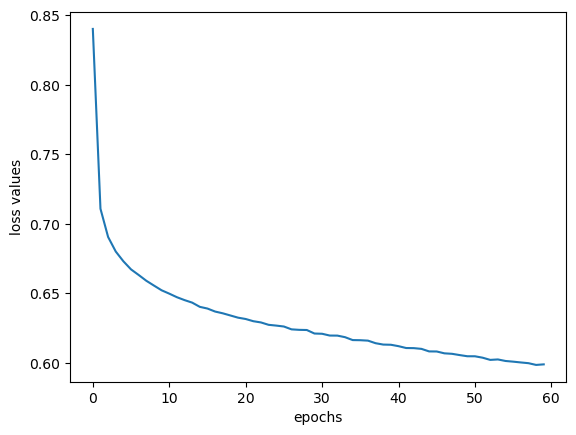

In [27]:
max_iter = 100
clf = MLPClassifier(max_iter = max_iter,alpha = 0,hidden_layer_sizes = (50,),
                   batch_size = 32)
clf.fit(X_train,y_train)
loss_values =clf.loss_curve_
#print(loss_values)
#print(len(loss_values))


plt.plot(loss_values)
plt.xlabel("epochs")
plt.ylabel("loss values")



- Using the testing dataset: 
    - Compute the overall accuracy for the classifier using the `MLPClassifier`'s `.score()` member method for both testing and training datasets.
    - Compute the confusion matrix (normalised in true labels), and plot it 
- Discuss the results

In [ ]:
print("Accuracy Training:",clf.score(X_train,y_train))
print("Accuracy Testing:",clf.score(X_test,y_test))


In [ ]:
fig = plt.figure()
matrix = ConfusionMatrixDisplay.from_estimator(
    clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true',
    display_labels=(('clear'),('cloudy'),('precip')))
plt.xlabel('Predicted weather')
plt.ylabel('Actual Weather')

## 4. Neural networks in `Keras` (2 marks)
---
This section covers exercises on constructing and training neural networks using the `Keras` library. `scikit-learn` is very easy to use, but libraries like `Keras` provide a lot more flexibility, which is why we will be using these extensively in the last two units of the _'Data science tools and machine learning'_ track.

In [28]:
# Relevant import(s) for this section
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense

#### 4.1. Construct a neural network in `Keras` (1 mark)

- Create a `keras.Model` using the **Keras functional API**. The network should have:
    - An input layer with the same number of nodes as the number of features in `X`.
    - A single, densely connected hidden layer with **50 nodes** equipped with **ReLU activation**.
    - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
- Compile the model the using the **Adam optimiser**, add `'accuracy'` as metric, and use either:
    - `categorical_crossentropy` loss, if you have one-hot encoded the targets `y`, or
    - `sparse_categorical_crossentropy` loss if you hare using integer-valued targets.
- Use the `.summary()` member method to print an overview of the model you have created, explain the output.

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7350, 23)
(3150, 23)
(7350,)
(3150,)


In [29]:
inputs = Input(shape=(23,))
hidden_layer = Dense(50, activation=tf.nn.relu)(inputs)
outputs = Dense(3, activation=tf.nn.softmax)(hidden_layer)

model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics =['accuracy'])

model.summary()
#This sumamry shows input layer with 23 nodes in a column with 0 parameters
#a hidden layer with 50 nodes (shape None,50) with 1200 parameters
#and the output layer with 3 nodes(shape None,3) with 153 parameters.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1200      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 1,353
Trainable params: 1,353
Non-trainable params: 0
_________________________________________________________________


#### 4.2. Train a `Keras` neural network (1 mark)

- Use the `.fit()` member method to train the network on the **training dataset** for **100 epochs** with a **batch size of 32**. Use **20% of the data for validation** and make sure to have `Keras` **shuffle** the training data between epochs. Save the fit history by doing `history_mld = .....`
- Print the classification accuracy using the `.evaluate()` member method, for both the training and testing dataset. Comment on the results.
- Plot val_loss and loss functions from the fit history. On the same plot, plot the sklearn curve from the excercise above. Note the sklearn NN does not provide a complementary validation loss history, so only plot the training loss.
- Comment on the results of the overall accuracy compared to the scikit-learn method.

In [32]:
print(y_train.shape)

(7350,)


In [ ]:
history= model.fit(X_train,y_train,batch_size = 32,epochs = 100,shuffle = True,validation_split = 0.2)
val_loss, val_accuracy =model.evaluate(X_train,y_train)
loss, accuracy = model.evaluate(X_test,y_test)


print("Training loss, training accuracy:",val_loss, val_accuracy )
print("Test loss, test accuracy:",loss, accuracy)

#The training set accuracy is and test set accuracy are quite similar but the training set accuracy
#is higher as expect.
#The training data loss is significantly lower than the test data loss which suggests that the model
#has not been underfit


In [1]:
print(history.history.keys())
#Similar results to sk-learn model above


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(loss_values)
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss',"skilearn loss"], loc='upper right')
plt.show()

#Loss on the training set for keras is very similar to the loss in the skilearn method
#As expected the validation loss is higher than the training loss.


NameError: name 'history' is not defined

## 5. Regularisation (1.5 marks)
---
This section covers **2** exercises on the impact of weight regularisaton. Note that $L_{1}$- and $L_{2}$-regularisation may also be applied to the activation of intermediate layers. Also, a similar regularising effect could be achieved using **dropout** regularisation, which you are encouraged to try out, but which we won't study in this CP exercise.

In [ ]:
# Relevant import(s) for this section
from tensorflow.python.keras.regularizers import l1_l2

#### 5.1. Define `Keras` model factory method (0.5 mark)

- Define a python function called `big_model_fn` which takes the followng three arguments:
    - `l1`: A float specifying the $L_{1}$ regularisation factor (default value: 0)
    - `l2`: A float specifying the $L_{2}$ regularisation factor (default value: 0)
    - `name`: A string, specifying the name of the model (default value: None)
- Indside the function, you should:
    - Construct a `Keras` model using the functional API, which has:
        - An input layer with the same number of nodes as the number of features in `X`.
        - **Two** densely connected hidden layer with **100 nodes** each, both equipped with **ReLU activation**.
        - Both hidden layers should be subject to kernel regularisation (_i.e._ weight regularisation) with the regularisation factors specified as an input.
        - A densely connected output layer with **3 nodes** (the number of types of weather we're classifying) equipped with **softmax activation**.
        - A name given by the corresponding argument.
    - Compile the model in the same way as in **Exercise 14.**
- The function should return the compiled `Keras` model. 

The method will provide a convenient way of constructing and compiling a number of "big"/deep `Keras` models which differ only by their regularisation and name.

In [ ]:
def big_model_fn(l1=0,l2=0,name=None):
    inputs = Input(shape=(23,))
    hidden_layer1 = Dense(100, activation=tf.nn.relu, kernel_regularizer = l1_l2(l1=l1, l2=l2))(inputs)
    hidden_layer2 = Dense(100, activation=tf.nn.relu, kernel_regularizer = l1_l2(l1=l1 , l2=l2))(hidden_layer1)
    outputs = Dense(3, activation=tf.nn.softmax)(hidden_layer2)

    model = Model(name = name, inputs=inputs, outputs=outputs)
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics =['accuracy'])

    return model.fit(X_train,y_train,batch_size = 32,epochs = 100,shuffle = True,validation_split = 0.2)


#### 5.2. Train "big" models with and without regularisation (1 mark)

- Construct three "big" model using the factory method:
     - One with default parameters
     - One with `l1=0.003` and  `name='model_L1'`
     - One with `l2=0.03`  and `name='model_L2'`
- Train each one as in **Exercise 15.**
- Compare first the loss history of the un-regularised "big" model to that of the small model from **Exercise 15** using the `plot.loss()` method.
- Then, compare the loss histories of all three "big" models with that of the small model.
- Plot the loss and val loss of all 4 models. Target these points:
    - Compare the performance of deep vs shallow models on the testing sets
    - Compare the level of ovetraining (training vs testing loss)
    - Note: Don't be alarmed if the shallow network performs slightly better that the deeper ones, this is dataset dependant.
- Copy the same plotting code, but this time plot the training and validation accuracy
- Discuss the results.

In [ ]:
history1 = big_model_fn(0,0,None)
history2 = big_model_fn(0.003,0,'model_L1')
history3 = big_model_fn(0.03,0,'model_L2')


In [ ]:
fig, ax = plt.subplots()
ax.plot(history1.history['loss'])
ax.plot(history2.history['loss'])
ax.plot(history3.history['loss'])
ax.plot(history.history['loss'])
ax.plot(history1.history['val_loss'])
ax.plot(history2.history['val_loss'])
ax.plot(history3.history['val_loss'])
ax.plot(history.history['val_loss'])
ax.set_ylim(0.2,2)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('model loss')
ax.legend(['unregularised loss', 'regularisation = 0.003 loss','regularisation =0.03 loss','shallow loss',
              'unregularised val_loss','regularisation = 0.003 val_loss','regularisation = 0.03 val_loss','shallow val_loss' ], loc='upper right')

#See below for zoomed in plot
#The shallow NN performs best overall with low loss on the training set and the low 
#loss on the testing set.
#The regularised deep NNs are underfit. The models have a similar loss on the training and validation sets.
#The unregularised deep NN is overfit. There is very low loss on the training set, but high loss
#on the testing set

In [ ]:
fig, ax = plt.subplots()
ax.plot(history1.history['loss'])
ax.plot(history2.history['loss'])
ax.plot(history3.history['loss'])
ax.plot(history.history['loss'])
ax.plot(history1.history['val_loss'])
ax.plot(history2.history['val_loss'])
ax.plot(history3.history['val_loss'])
ax.plot(history.history['val_loss'])
ax.set_ylim(0.2,0.9)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.set_title('zoomed in model loss')
ax.legend(['unregularised loss', 'regularisation = 0.003 loss','regularisation =0.03 loss','shallow loss',
              'unregularised val_loss','regularisation = 0.003 val_loss','regularisation = 0.03 val_loss','shallow val_loss' ], loc='lower left')

In [ ]:
fig, ax = plt.subplots()
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')

ax.set_ylim(0.55)
plt.xlabel('epoch')
plt.title('model accuracy')
plt.legend(['unregularised', 'regularisation = 0.003','regularisation =0.03','shallow',
            'unregularised val_accuracy','regularisation = 0.003 val_accuracy','regularisation = 0.03 val_accuracy' ], loc='lower right')
#As expected overfit unregularised deep NN has the highest accuracy, but low validation accuracy
#we see the shallow NN with a high accuracy.
#Following this is both the regularised validation  sets.
#We confirm that the regularised deep NNs are underfit since they are as/more accurate on validation sets as they 
#are on the training data.